In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
!pip install gensim
import nltk
!pip install torchmetrics
# !pip install mca
from matplotlib import pyplot as plt
import seaborn as sns
!pip install spicy
# !pip install wordcloud
# !pip install umap-learn

# from wordcloud import WordCloud
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/imdb-50k-movie-reviews-test-your-bert/train.csv
/kaggle/input/imdb-50k-movie-reviews-test-your-bert/test.csv


# Data preprocessing : Stop words , Stemming and normalising

In [2]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem.snowball import SnowballStemmer
import nltk
import numpy as np
train=pd.read_csv("/kaggle/input/imdb-50k-movie-reviews-test-your-bert/train.csv")
valid=pd.read_csv("/kaggle/input/imdb-50k-movie-reviews-test-your-bert/test.csv")

train["sentiment"] = train["sentiment"] != "neg"
valid["sentiment"] = valid["sentiment"] != "neg"

In [3]:
# from nltk.corpus import wordnet

# def get_wordnet_pos(treebank_tag):

#     if treebank_tag.startswith('J'):
#         return wordnet.ADJ
#     elif treebank_tag.startswith('V'):
#         return wordnet.VERB
#     elif treebank_tag.startswith('N'):
#         return wordnet.NOUN
#     elif treebank_tag.startswith('R'):
#         return wordnet.ADV
#     else:
#         return None

# from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer
# import numpy as np
# wnl = WordNetLemmatizer()
# eng_stop_words = stopwords.words('english')
# def process_text(text):
#     word_tokens = nltk.word_tokenize(text)
#     post_tagged = list(map(lambda d: (d[0],get_wordnet_pos(d[1])),nltk.pos_tag(word_tokens)))
#     lemmatized_word = [wnl.lemmatize(w[0],w[1]) if w[1] != None else wnl.lemmatize(w[0]) for w in post_tagged ]
#     final = [w for w in lemmatized_word if w not in eng_stop_words]
#     return " ".join(lemmatized_word)
# v_process_text = np.vectorize(process_text)
# train["p_text"] = v_process_text(train["text"].sample(30))

In [4]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import numpy as np
snb = SnowballStemmer(language="english")
eng_stop_words = set(stopwords.words('english'))
def process_text_small(key):
    return snb.stem(key) if key not in eng_stop_words else " "
v_process_text_small = np.vectorize(process_text_small)
train["p_text"] = v_process_text_small(train["text"])

## Count Vectorizer , 2-grams  and Multinomial NB

Train Accuracy 0.9927792207792208


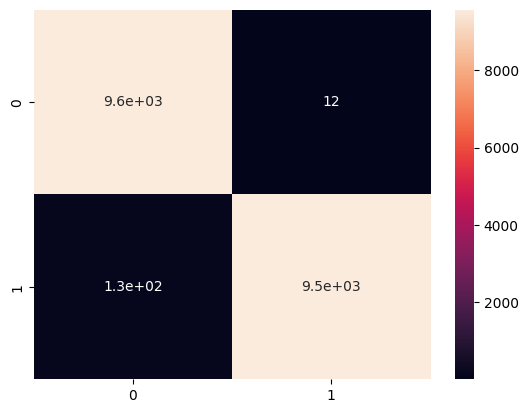

Valid Accuracy 0.8786086956521739


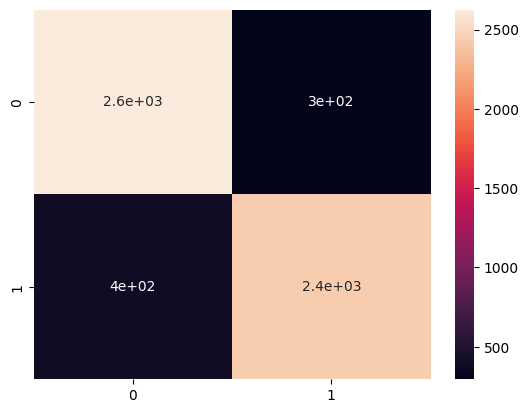

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix
cv = CountVectorizer(ngram_range=(1,2))
X = cv.fit_transform(train["p_text"])
y = train["sentiment"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.23, random_state=0)
mnb = MultinomialNB()
mnb.fit(X_train,y_train)
train_pred = mnb.predict(X_train) > 0.5
print(f"Train Accuracy {accuracy_score(y_train,train_pred)}")
sns.heatmap(confusion_matrix(y_train,train_pred),annot=True)
plt.show()

valid_pred = mnb.predict(X_valid)  > 0.5
print(f"Valid Accuracy {accuracy_score(y_valid,valid_pred)}")
sns.heatmap(confusion_matrix(y_valid,valid_pred),annot=True)
plt.show()

## TFIDF And Count with 2 grams : XGBoost

Model Time
Train Accuracy 0.93385


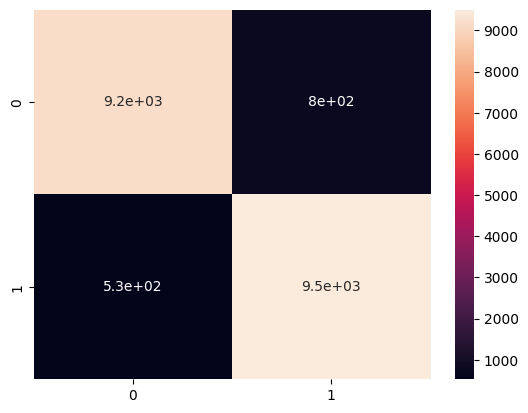

Valid Accuracy 0.851


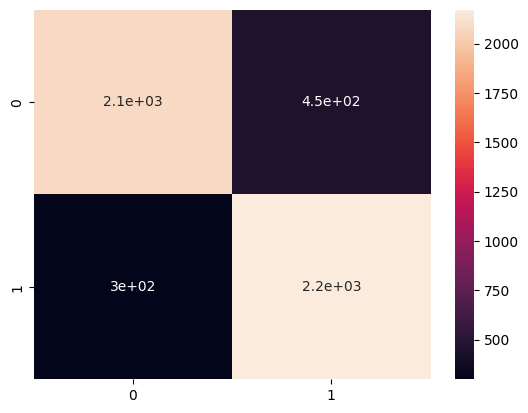

In [33]:
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from scipy.sparse import hstack
tfidf = TfidfVectorizer(ngram_range=(1,2))
cv = CountVectorizer(ngram_range=(1,2))
X_cv = cv.fit_transform(train["p_text"])
X_tfidf = tfidf.fit_transform(train["p_text"])
X = hstack([X_cv,X_tfidf])
y = train["sentiment"]
print("Model Time")
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = XGBClassifier(n_estimators=200,max_depth=3)
gnb.fit(X_train,y_train)
train_pred = gnb.predict(X_train)
print(f"Train Accuracy {accuracy_score(y_train,train_pred)}")
sns.heatmap(confusion_matrix(y_train,train_pred),annot=True)
plt.show()

valid_pred = gnb.predict(X_valid)
print(f"Valid Accuracy {accuracy_score(y_valid,valid_pred)}")
sns.heatmap(confusion_matrix(y_valid,valid_pred),annot=True)
plt.show()

## Catboost with 2 grams

Train Accuracy 0.9483636363636364


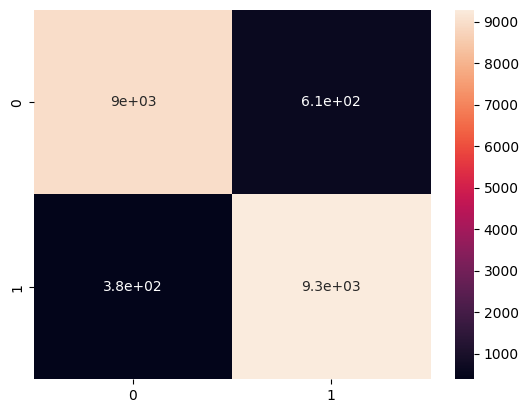

Valid Accuracy 0.8622608695652174


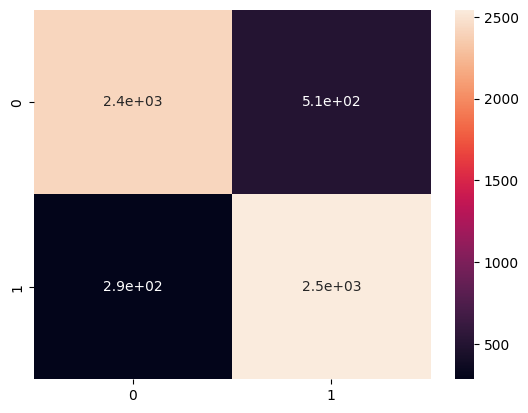

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import CatBoostRegressor
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(train["p_text"])
y = train["sentiment"].astype("float64")
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.23, random_state=0)
gnb = CatBoostRegressor()
gnb.fit(X_train,y_train,silent=True)
train_pred = gnb.predict(X_train) > 0.5
print(f"Train Accuracy {accuracy_score(y_train,train_pred)}")
sns.heatmap(confusion_matrix(y_train,train_pred),annot=True)
plt.show()

valid_pred = gnb.predict(X_valid) > 0.5
print(f"Valid Accuracy {accuracy_score(y_valid,valid_pred)}")
sns.heatmap(confusion_matrix(y_valid,valid_pred),annot=True)
plt.show()

In [35]:
# import os
# os.environ['GENSIM_DATA_DIR'] = '/kaggle/working/gensim-data'

# import gensim.downloader as api
# # embed = api.load('word2vec-google-news-300')
# embed = api.load('fasttext-wiki-news-subwords-300')
# # embed = api.load("glove-twitter-25")

# # embed = api.load("glove-wiki-gigaword-50")

# # pd.DataFrame(api.info()).index[pd.DataFrame(api.info()).index.str.contains("glove")]

In [36]:
# def get_embeddings(text):
#     lel = pd.Series([embed[w] for w in text if w in embed])
#     return lel.mean()
# train_embeddings = train["p_text"].apply(lambda d : get_embeddings(d))
# train_embeddings = pd.DataFrame.from_records(train_embeddings)

In [ ]:
# from gensim.models import FastText
# #Custom Trained Embeddings approach 
# custom_embedding = FastText(vector_size=300)
# custom_embedding.build_vocab(train["text"])
# custom_embedding.wv.vectors_lockf = np.ones(len(custom_embedding.wv))
# custom_embedding.wv.intersect_word2vec_format('/kaggle/working/gensim-data/fasttext-wiki-news-subwords-300/fasttext-wiki-news-subwords-300.gz')
# custom_embedding.train(corpus_iterable=train["text"], total_examples=len(train["text"]), epochs=100)

In [ ]:
# print(custom_embedding)

In [ ]:
# cembed = custom_embedding.wv
# cembed,embed

In [ ]:
# embed.most_similar(["king","women"],negative=["men"]),cembed.most_similar(["king","women"],negative=["men"])

# Preparing data for DL models

In [7]:
from random import randint
from collections import defaultdict 
UNK_TOKEN  = "<unk>"
PAD_TOKEN = "<pad>"
def get_vocab(val):
    tokens = nltk.word_tokenize(" ".join(val))
    vocab = set(tokens)
    vocab.add(UNK_TOKEN)
    vocab_dict = dict((y,x+1)for x,y in enumerate(vocab))
    vocab_dict[PAD_TOKEN]=0
    return vocab,vocab_dict
vocab,vocab_dict = get_vocab(train["p_text"].values)
vocab_dict = defaultdict(lambda :vocab_dict[UNK_TOKEN],vocab_dict)
len(vocab)

114675

In [8]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:

# import torch
# from torch.utils.data import DataLoader,Dataset
# class ImDBDataSet(Dataset):
#     def __init__(self, data):
#         self.data = data

#     def __len__(self):
#         return self.data.shape[0]

#     def __getitem__(self, idx):
#         d = self.data.iloc[idx]
#         words = [torch.tensor(embed[w])*7 if w in embed else torch.zeros(300) for w in  d["text"] ]
#         return words, torch.tensor([1.0]) if d["sentiment"] > 0 else torch.tensor([0.0])
        
# def collate_fn(x):
#     xs = []
#     ys = []
#     for data in x:
#         xs.append(torch.stack(data[0]))
#         ys.append(data[1])
#     return torch.nn.utils.rnn.pad_sequence(xs,batch_first =True),torch.stack(ys)
# train_dataset = ImDBDataSet(train.assign(sz = lambda x: len(x["text"]) ).sort_values("sz")[:256+32])
# valid_dataset = ImDBDataSet(valid.assign(sz = lambda x: len(x["text"]) ).sort_values("sz")[:128])


In [10]:
import torch
from torch.utils.data import DataLoader,Dataset
class ImDBDataSet(Dataset):
    def __init__(self, data,valid=False):
        self.data = data
        self.valid = valid
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        d = self.data.iloc[idx]
        words = [vocab_dict[w]  if randint(0,100) != 1 or self.valid == True else vocab_dict[UNK_TOKEN]  for w in d["text"] ]
        return torch.tensor(words), torch.tensor([1.0]) if d["sentiment"] > 0 else torch.tensor([0.0])
        
def collate_fn(x):
    xs = []
    ys = []
    for data in x:
        xs.append(data[0])
        ys.append(data[1])
    return (torch.nn.utils.rnn.pad_sequence(xs,batch_first =True)),torch.stack(ys)
train_dataset = ImDBDataSet(train.assign(sz = lambda x: len(x["text"]) ).sort_values("sz"))
valid_dataset = ImDBDataSet(valid.assign(sz = lambda x: len(x["text"]) ).sort_values("sz"),valid=True)


In [22]:
NUM_EPOCH = 20
LR = 0.002
BATCH_SIZE = 64
HIDDEN_LAYER = 256
DEEP_RNN_LAYERS = 1
EMBED_DIM = 128
assert DEEP_RNN_LAYERS == 1 # needs to be one or i change code

In [23]:
train_loader = DataLoader(train_dataset,BATCH_SIZE,shuffle=True,collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset,BATCH_SIZE,shuffle=True,collate_fn=collate_fn)

In [24]:
# class GRU(torch.nn.Module):
#     def __init__(self,hidden_layer_size,inp_size):
#         super().__init__()
#         self.forget = torch.nn.Sequential(torch.nn.Linear(hidden_layer_size+inp_size,hidden_layer_size),torch.nn.Sigmoid())
#         self.scaling = torch.nn.Sequential(torch.nn.Linear(hidden_layer_size+inp_size,hidden_layer_size),torch.nn.Sigmoid())
#         self.new_hidden = torch.nn.Sequential(torch.nn.Linear(hidden_layer_size+inp_size,hidden_layer_size),torch.nn.ReLU())
#     def step(self,hidden_val,x):
#         z = self.forget(torch.cat([hidden_val,x],dim=1))
#         r = self.scaling(torch.cat([hidden_val,x],dim=1))
#         c_n = self.new_hidden(torch.cat([r*hidden_val,x],dim=1))
#         h_n = z*c_n + (1-z)*hidden_val
#         return h_n
#     def forward(self,init_hidden,inp):
#         hidden = init_hidden
#         x = inp.transpose(0,1)
#         for bw_i in x:
#             hidden = self.step(hidden,bw_i)
#         return hidden


In [25]:
# class RCNN(torch.nn.Module):
#     def __init__(self,inp_size):
#         super().__init__()
#         self.embeddings = torch.nn.Embedding(inp_size,EMBED_DIM)
#         self.conv =torch.nn.Sequential(RCNN.get_conv(EMBED_DIM,256,k=6,s=2),RCNN.get_conv(256,512,k=4),RCNN.get_conv(512,512,k=3))
#         self.recurent = torch.nn.GRU(512,HIDDEN_LAYER,DEEP_RNN_LAYERS,batch_first=True,dropout=0.1)
#         self.head = torch.nn.Linear(HIDDEN_LAYER,1)

#     def get_conv(i,o,k=3,s=1):
#         return torch.nn.Sequential(torch.nn.Conv1d(i,o,kernel_size=(k),stride=(s)),torch.nn.Conv1d(o,o,kernel_size=(k),stride=(s)),torch.nn.Conv1d(o,o,kernel_size=(k),stride=(s*2)),torch.nn.InstanceNorm1d(o),torch.nn.Dropout(p=0.35),torch.nn.LeakyReLU(0.1))
    
#     def forward(self,inp):
#         x = self.embeddings(inp)
#         x = self.conv(x.transpose(1,2)).permute(0,2,1)
#         x = torch.nn.utils.rnn.pad_sequence(x,batch_first =True)
#         out,hidden= self.recurent(x)
#         hidden=hidden.view(-1,HIDDEN_LAYER)
#         return self.head(hidden)


In [26]:
class CNN(torch.nn.Module):
    def __init__(self,inp_size):
        super().__init__()
        self.embeddings = torch.nn.Embedding(inp_size,EMBED_DIM)
        self.conv =torch.nn.Sequential(CNN.get_conv(EMBED_DIM,64,k=6,s=2),CNN.get_conv(64,128,k=4),torch.nn.AdaptiveAvgPool1d(16))
        self.head = torch.nn.Linear(16*128,1)

    def get_conv(i,o,k=3,s=1):
        return torch.nn.Sequential(torch.nn.Conv1d(i,o,kernel_size=(k),stride=(s)),torch.nn.Conv1d(o,o,kernel_size=(k),stride=(s)),torch.nn.Conv1d(o,o,kernel_size=(k),stride=(s*2)),torch.nn.InstanceNorm1d(o),torch.nn.Dropout(p=0.35),torch.nn.LeakyReLU(0.1))
    
    def forward(self,inp):
        x = self.embeddings(inp)
        x = self.conv(x.transpose(1,2)).permute(0,2,1)
        return self.head(x.reshape(-1,16*128))


In [27]:
class EGRU(torch.nn.Module):
    def __init__(self,inp_size):
        super().__init__()
        self.embeddings = torch.nn.Embedding(inp_size,EMBED_DIM)
        self.recurent = torch.nn.GRU(EMBED_DIM,HIDDEN_LAYER,DEEP_RNN_LAYERS,batch_first=True,dropout=0.15)
        self.head = torch.nn.Linear(HIDDEN_LAYER,1)

    def forward(self,inp):
        x = self.embeddings(inp)
        x = torch.nn.utils.rnn.pad_sequence(x,batch_first =True)
        out,hidden= self.recurent(x)
        hidden=hidden.view(-1,HIDDEN_LAYER)
        return self.head(hidden)
            

In [28]:
# class Encoder(torch.nn.Module):
#     def __init__(self,hidden_layer):
#         super().__init__()
# #         self.rnn = torch.nn.RNN(300,hidden_layer,DEEP_RNN_LAYERS,batch_first=True,nonlinearity='relu')
#         self.dense =torch.nn.Sequential(torch.nn.Linear(hidden_layer * DEEP_RNN_LAYERS,128),torch.nn.Linear(128,1))
#         self.cnn = CNN(300)

#     def forward(self,x):
#         x = x.transpose(1,2)
#         x = self.cnn(x)
#         print(x.view(-1,2048).shape)
#         return self.dense(x.view(-1,2048))

In [29]:
def predict_step(encoder,x_train,y_train,loss):
    hidden = encoder(x_train)
    y_train_pred = hidden
    batch_loss = loss(y_train_pred.view(-1),y_train.view(-1))
    return batch_loss,y_train_pred

In [30]:
from torchmetrics.classification import BinaryAccuracy
def validate_model(model):
    bce_loss = torch.nn.BCEWithLogitsLoss().to(device)
    acc = BinaryAccuracy().to(device)
    val_iter = iter(valid_loader)
    model.eval()
    loss = 0
    with torch.no_grad():
        for batch_iter,(x_valid,y_valid) in enumerate(val_iter):
            x_valid = x_valid.to(device)
            y_valid = y_valid.to(device)
            batch_loss,output = predict_step(model,x_valid,y_valid,bce_loss)
            loss+= batch_loss
            acc(output.view(-1),y_valid.view(-1))
            
    return loss,acc.compute()

In [31]:
import gc
def full_train_validate(encoder_md,epochs,lr):
    gc.collect()
    torch.cuda.empty_cache()
    encoder = encoder_md(len(vocab)).to(device)
    optimizer = torch.optim.Adam(encoder.parameters(),lr=lr)
    bce_loss = torch.nn.BCEWithLogitsLoss().to(device)
    for e in range(epochs):
        train_acc = BinaryAccuracy().to(device)
        train_iter = iter(train_loader)
        loss = 0
        for batch_iter,(x_train,y_train) in enumerate(train_iter):

            optimizer.zero_grad()
            encoder.train()

            x_train = x_train.to(device)
            y_train = y_train.to(device)

            batch_loss,y_train_pred = predict_step(encoder,x_train,y_train,bce_loss)
            batch_loss.backward()

    #         torch.nn.utils.clip_grad_norm_(encoder.parameters(), 0.005)
            optimizer.step()


            with torch.no_grad():
                loss += batch_loss
                batch_acc=train_acc(y_train_pred.view(-1),y_train.view(-1))
                if(batch_iter % 100 == 0 and batch_iter != 0 ):
                    print(f"Batch {batch_iter} : - {batch_loss} - Acc {batch_acc}")
        with torch.no_grad():
            print(f"Train Epoch {e} : - {loss} Accuracy : {train_acc.compute()}")
            if e >= 4 :
                valid_loss,valid_acc = validate_model(encoder)
                print(f" ( Valid Epoch {e} : - {valid_loss} Accuracy : {valid_acc} ) ")


# GRU with Embedding 

In [32]:
full_train_validate(EGRU,NUM_EPOCH,LR)

Batch 100 : - 0.6990605592727661 - Acc 0.5
Batch 200 : - 0.6931992769241333 - Acc 0.453125
Batch 300 : - 0.6962705850601196 - Acc 0.515625
Train Epoch 0 : - 273.0250244140625 Accuracy : 0.5006399750709534
Batch 100 : - 0.6906615495681763 - Acc 0.515625
Batch 200 : - 0.6926403641700745 - Acc 0.546875
Batch 300 : - 0.690373420715332 - Acc 0.46875
Train Epoch 1 : - 271.67608642578125 Accuracy : 0.5030800104141235
Batch 100 : - 0.6953062415122986 - Acc 0.5
Batch 200 : - 0.6951276659965515 - Acc 0.515625
Batch 300 : - 0.6840252876281738 - Acc 0.4375
Train Epoch 2 : - 271.48724365234375 Accuracy : 0.5026000142097473
Batch 100 : - 0.6959226131439209 - Acc 0.5
Batch 200 : - 0.700107991695404 - Acc 0.390625
Batch 300 : - 0.7013592720031738 - Acc 0.5625
Train Epoch 3 : - 271.8880310058594 Accuracy : 0.4972800016403198
Batch 100 : - 0.7000045776367188 - Acc 0.46875
Batch 200 : - 0.6948906779289246 - Acc 0.5
Batch 300 : - 0.6969255805015564 - Acc 0.546875
Train Epoch 4 : - 269.5464172363281 Accura

## 1DCNN Feed Forward 

In [19]:
NUM_EPOCH = 35
LR = 0.0065
full_train_validate(CNN,NUM_EPOCH,LR)

Batch 100 : - 0.764586329460144 - Acc 0.484375
Batch 200 : - 0.7743898034095764 - Acc 0.4375
Batch 300 : - 0.8766180276870728 - Acc 0.421875
Train Epoch 0 : - 301.6509704589844 Accuracy : 0.502240002155304
Batch 100 : - 0.7629286050796509 - Acc 0.53125
Batch 200 : - 0.8013519048690796 - Acc 0.453125
Batch 300 : - 0.7258762121200562 - Acc 0.53125
Train Epoch 1 : - 308.104248046875 Accuracy : 0.5042399764060974
Batch 100 : - 0.6885068416595459 - Acc 0.515625
Batch 200 : - 0.6757943630218506 - Acc 0.640625
Batch 300 : - 0.7394174933433533 - Acc 0.5
Train Epoch 2 : - 281.2165222167969 Accuracy : 0.5055999755859375
Batch 100 : - 0.6705131530761719 - Acc 0.53125
Batch 200 : - 0.7323119640350342 - Acc 0.453125
Batch 300 : - 0.7467770576477051 - Acc 0.5
Train Epoch 3 : - 280.4716491699219 Accuracy : 0.4976400136947632
Batch 100 : - 0.7042996883392334 - Acc 0.515625
Batch 200 : - 0.6965745091438293 - Acc 0.515625
Batch 300 : - 0.6946097612380981 - Acc 0.515625
Train Epoch 4 : - 279.054229736328

In [ ]:
# TODO 
# try to add more features  : Noh cause of not using Naive bayes , takes lot of time 
# 2 grams , Markov Models
# Embeddings , Start only with word 2 vec wibda zid 
# Look at dimensionality reduction techniques , mca etc : Too sparse , word embeddins are the key !
# use embeddings for prediction + add more features if possible 
# Similarity Measures  , Clustering with Kmeans , Hierichial clusteirng , LDA on the embedd maybe ,ICA etc , Topic Modeling ( project in general : LDA , NMF , LSI etc )
# For topic modeling and similarity measures , go with another data set is better !
# Mixture Models to get words that follow a Similar Inherent Disteibution